In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import matthews_corrcoef, classification_report, log_loss, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import importlib


In [14]:
# Gestione import modulo target
try:
    import target
    importlib.reload(target)
    from target import calculate_target
    from target import TICKER
except ImportError:
    print("Errore: File 'target.py' non trovato. Assicurati che sia nella stessa cartella.")
    exit()

# Seed per riproducibilità
tf.random.set_seed(42)
np.random.seed(42)

# --- CONFIGURAZIONE ---
LOOK_BACK = 15         # Finestra temporale LSTM
BATCH_SIZE = 32
EPOCHS = 50
WINDOW_SIZE_K = 40      # Finestra media mobile per la soglia
FLOOR_PROBABILITY = 0.40
STARTING_CASH = 1000    # Capitale per la simulazione
COMMISSION_INTEREST = 0.002 #Costi di commissione


print(f"--- 1. Caricamento e Preparazione Dati ({TICKER}) ---")

df = pd.read_csv(
    f"csv/{TICKER}_indicators.csv",
    index_col=0,
    parse_dates=[0],
    date_format="ISO8601"
) 

TimeSplit_up = "2025-11-28"
TimeSplit_down = "2024-09-26"

start_dt = pd.to_datetime(TimeSplit_down)
end_dt = pd.to_datetime(TimeSplit_up)

app = df.loc[(df.index < start_dt)]
app = app.iloc[-LOOK_BACK:]


trading_df = df.loc[(df.index >= start_dt) & (df.index <= end_dt)].copy()


# Calcolo Target
target_window = 5
df['Target'] = calculate_target(df, window=target_window, profit_take_pct=2.0, stop_loss_pct=1.0)
df.dropna(subset=['Target'], inplace=True) 
df['Target'] = df['Target'].astype(int)

# Feature Selection
features = [
    'Close', 'High', 'Volume', 'Return', 'MACD', 'MACD_Hist', 'SMA', 'EMA20', 
    'Vol_EMA20', 'RSI', 'Boll_Up', 'Boll_Down', 'Dist_low_band', 'Dist_up_band', 
    '%K', '%D', 'R_EMA20', 'ADX', 'ATR', 'ROC', 'OBV', 'CMF', 'MACD_norm', 
    'RSI_diff', 'DI_diff', 'SMA_slope', 'RSI_slope', 'MACD_slope', '%K_slope', 
    'ATR_slope', 'OBV_slope', 'ADX_slope', 'RSI_overbought', 'RSI_oversold', 
    'Stoch_overbought', 'Stoch_oversold', 'MACD_crossover_signal', 'Vol_pct_change', 
    'RSI_x_Vol_Change', 'ATR_pct', 'RSI_SMA15', 'RSI_vs_SMA', 'MACD_Hist_Std20', 
    'SP_Return', 'SP_RSI', 'SP_Dist_SMA'
]

# Rimuovi feature mancanti se necessario
features = [c for c in features if c in df.columns]

# Split Cronologico
train_size = int(len(df) * 0.70)
val_size = int(len(df) * 0.15)

train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size + val_size]
test_df = df.iloc[train_size + val_size:]

print(f"Periodo Test: {test_df.index[0].date()} -> {test_df.index[-1].date()}")

# Scaling
feature_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = feature_scaler.fit_transform(train_df[features])
x_val_scaled = feature_scaler.transform(val_df[features])
x_test_scaled = feature_scaler.transform(test_df[features])

combined = pd.concat([app,trading_df])
x_trade_scaled = feature_scaler.transform(combined[features])

y_train = train_df['Target'].values
y_val = val_df['Target'].values
y_test = test_df['Target'].values

# Creazione Sequenze 3D
def create_sequences(X, y, look_back):
    """
    Trasforma dati 2D in sequenze temporali 3D per LSTM.
    
    Parametri:
    - X: array 2D (samples, features) - dati scalati
    - y: array 1D target (opzionale) - se None, ritorna solo X
    - look_back: int - lunghezza finestra temporale
    
    Ritorno:
    - Se y è fornito: (X_sequences, y_sequences)
      - X_sequences: (samples-look_back, look_back, features)
      - y_sequences: (samples-look_back,) target allineati
    - Se y è None: solo X_sequences per predizioni
    
    Esempio: con look_back=15, ogni sample contiene 15 giorni di dati
    per predire il target del 16° giorno.
    """
    Xs, ys = [], []
    if y is not None:
        for i in range(len(X) - look_back):
            Xs.append(X[i:(i + look_back)])
            ys.append(y[i + look_back]) 
        return np.array(Xs), np.array(ys)
    
    for i in range(len(X) - look_back):
            Xs.append(X[i:(i + look_back)])
    return np.array(Xs)

X_train_3d, y_train_seq = create_sequences(x_train_scaled, y_train, LOOK_BACK)
X_val_3d, y_val_seq = create_sequences(x_val_scaled, y_val, LOOK_BACK)
X_test_3d, y_test_seq = create_sequences(x_test_scaled, y_test, LOOK_BACK)

X_trading_3d = create_sequences(x_trade_scaled,None,LOOK_BACK)
print(len(X_trading_3d))

--- 1. Caricamento e Preparazione Dati (AAPL) ---
Periodo Test: 2024-09-26 -> 2025-11-20
295


Se si vuole importare un modello esistente eseguire solo la seguente cella e non quella dopo

In [19]:
from tensorflow.keras.models import load_model
import os
from sklearn.metrics import confusion_matrix

# Se esiste un modello salvato, caricalo e sovrascrivi la variabile `model`
# Inoltre calcola val_probs per il calcolo della soglia dinamica
_model_path = 'models/lstm/lstm_model.keras'
if os.path.exists(_model_path):
    print(f"\n--- Caricamento modello esistente da: {_model_path} ---")
    model = load_model(_model_path)
    val_probs = model.predict(X_val_3d, verbose=0).flatten()
    val_series = pd.Series(val_probs)


_best_k_path = 'models/lstm/best_k.json'
if os.path.exists(_best_k_path):
    with open(_best_k_path, 'r') as f:
        import json
        best_k = float(json.load(f)['best_k'])




--- Caricamento modello esistente da: models/lstm/lstm_model.keras ---


In [ ]:
print("\n--- 2. Addestramento LSTM ---")



# - Input: sequenze 3D di LOOK_BACK giorni con len(features) indicatori
# - Dropout: 0.2 per regolarizzazione (previene overfitting) 
# - Dense: 1 neurone con sigmoid per probabilità [0,1]
# 
# Early Stopping: ferma training se val_loss non migliora per 20 epoche
# Class Weight: bilancia classi sbilanciate.

model = Sequential()
model.add(Input(shape=(LOOK_BACK, len(features))))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Pesi Classi
neg, pos = np.sum(y_train_seq == 0), np.sum(y_train_seq == 1)
total = neg + pos
class_weight = {0: (1/neg)*(total/2.0), 1: (1/pos)*(total/2.0)}

history = model.fit(
    X_train_3d, y_train_seq,
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    validation_data=(X_val_3d, y_val_seq),
    callbacks=[early_stop], class_weight=class_weight, verbose=1
)
print("Addestramento completato.")


print("\n--- 3. Tuning Soglia Dinamica (Best K) ---")

val_probs = model.predict(X_val_3d, verbose=0).flatten()
val_series = pd.Series(val_probs)

best_mcc = -1
best_k = 1.5 

for k in np.arange(0.5, 2.5, 0.1):
    roll_mean = val_series.rolling(window=WINDOW_SIZE_K).mean()
    roll_std = val_series.rolling(window=WINDOW_SIZE_K).std()
    
    thresh = roll_mean + roll_std.mul(float(k))
    thresh = np.maximum(thresh.fillna(FLOOR_PROBABILITY), FLOOR_PROBABILITY)
    
    preds = (val_series > thresh).fillna(False).astype(int)
    mcc = matthews_corrcoef(y_val_seq, preds)
    
    if mcc > best_mcc:
        best_mcc = mcc
        best_k = k

print(f"Best K trovato: {best_k:.1f} (MCC Val: {best_mcc:.4f})")


--- 2. Addestramento LSTM ---
Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.4644 - loss: 0.7009 - val_accuracy: 0.6423 - val_loss: 0.6695
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4839 - loss: 0.6956 - val_accuracy: 0.6423 - val_loss: 0.6696
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5094 - loss: 0.6932 - val_accuracy: 0.6423 - val_loss: 0.6700
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5109 - loss: 0.6931 - val_accuracy: 0.6387 - val_loss: 0.6727
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5124 - loss: 0.6915 - val_accuracy: 0.6387 - val_loss: 0.6702
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5154 - loss: 0.6916 - val_accuracy: 0.6423 - val_loss: 0.6657
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4944 - loss: 0.6938 - val_accuracy: 0.6241 - val_loss: 0.6712
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5258 - loss: 0.

In [17]:
import joblib
import json

# Definisci i nomi dei file
model_filename = 'models/lstm/lstm_model.keras'  # Formato nativo Keras moderno
scaler_filename = 'models/lstm/lstm_scaler.pkl'  # Formato standard joblib
best_k_filename = 'models/lstm/best_k.json'      # Parametro soglia dinamica

print("--- Salvataggio Modello e Scaler ---")

# 1. Salva il modello LSTM (Metodo nativo Keras)
# Salva architettura, pesi e stato dell'ottimizzatore
model.save(model_filename)
print(f"Modello salvato correttamente in: {model_filename}")

# 2. Salva lo Scaler (Metodo Joblib)
# FONDAMENTALE: Senza questo non potrai fare previsioni su nuovi dati
joblib.dump(feature_scaler, scaler_filename)
print(f"Scaler salvato correttamente in: {scaler_filename}")

# 3. Salva il parametro best_k (JSON)
try:
    with open(best_k_filename, 'w') as f:
        json.dump({"best_k": float(best_k)}, f)
    print(f"best_k salvato correttamente in: {best_k_filename}")
except Exception as e:
    print(f"Impossibile salvare best_k: {e}")

--- Salvataggio Modello e Scaler ---
Modello salvato correttamente in: models/lstm/lstm_model.keras
Scaler salvato correttamente in: models/lstm/lstm_scaler.pkl
best_k salvato correttamente in: models/lstm/best_k.json



--- 4b. Metriche Classificazione (Test) ---
              precision    recall  f1-score   support

           0       0.61      0.97      0.75       163
           1       0.67      0.09      0.16       112

    accuracy                           0.61       275
   macro avg       0.64      0.53      0.45       275
weighted avg       0.63      0.61      0.51       275



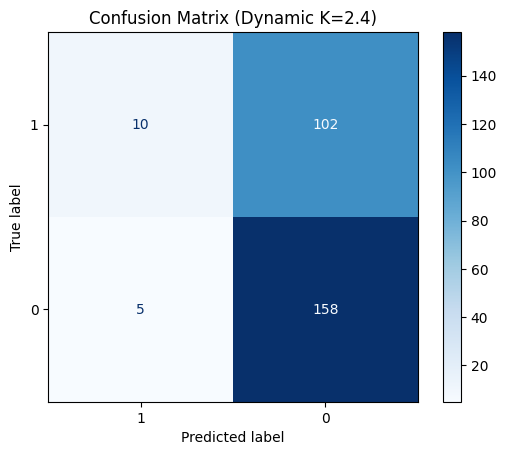

295
Giorni di Trading Effettivi: 295

--- Esecuzione Strategia ---

RISULTATI FINALI (AAPL)
Periodo: 2024-09-26 -> 2025-11-28
1. LSTM Model:    $1360.47 (+36.05%)
1. BUY & HOLD:    $1220.71 (+22.07%)

Trade eseguiti dal modello: 16


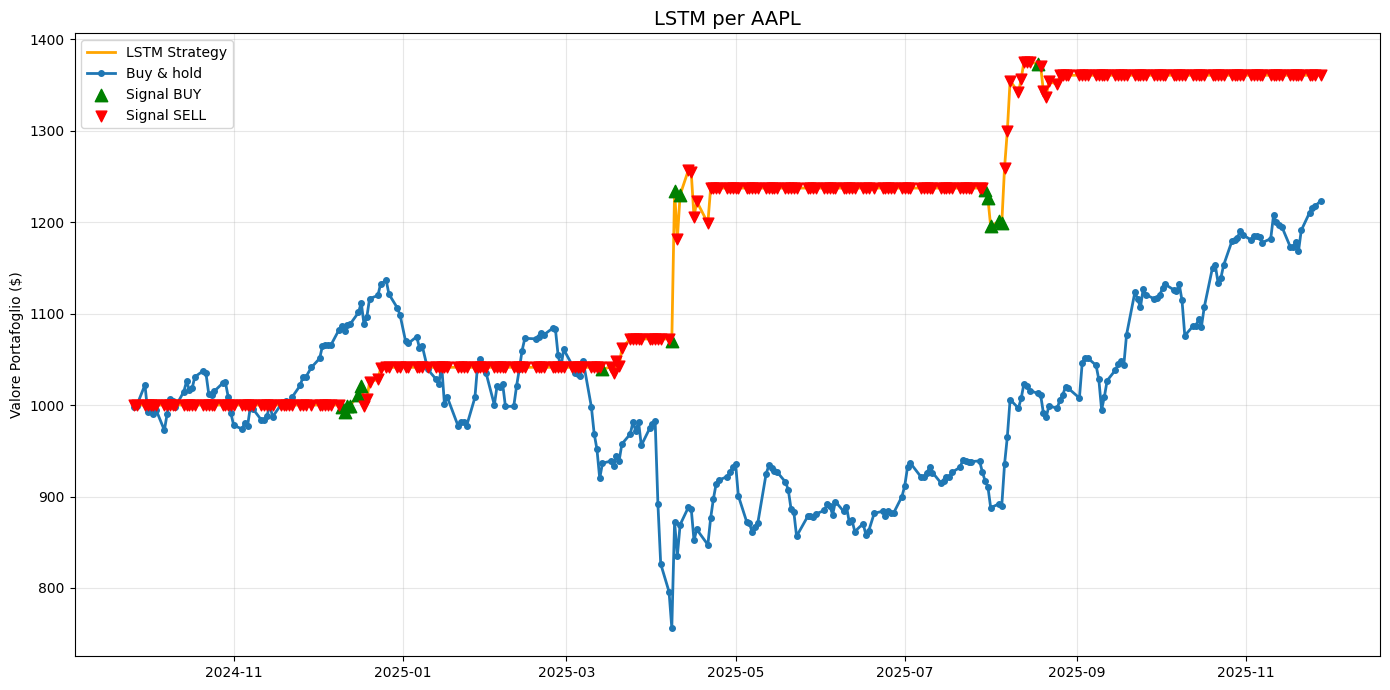

In [20]:
test_probs = model.predict(X_test_3d, verbose=0).flatten()
test_series = pd.Series(test_probs)

# Warm Start per la soglia (usiamo coda validation)
combined_series = pd.concat([val_series.iloc[-WINDOW_SIZE_K:], test_series]).reset_index(drop=True)
roll_mean_test = combined_series.rolling(window=WINDOW_SIZE_K).mean()
roll_std_test = combined_series.rolling(window=WINDOW_SIZE_K).std()

dynamic_thresh_test = roll_mean_test + roll_std_test.mul(float(best_k))
dynamic_thresh_test = np.maximum(dynamic_thresh_test.fillna(FLOOR_PROBABILITY), FLOOR_PROBABILITY)

# Rimuovi warm start
dynamic_thresh_test = dynamic_thresh_test.iloc[WINDOW_SIZE_K:].reset_index(drop=True)

# Genera Azioni Modello (1=Buy, 0=Wait/Sell)
model_actions = (test_series > dynamic_thresh_test).astype(int).values

# === Metriche di classificazione sul Test ===
print("\n--- 4b. Metriche Classificazione (Test) ---")
# y_test_seq è già allineato con X_test_3d
y_pred = model_actions

# Crea palette personalizzata gialla intorno al #C09A00
from matplotlib.colors import LinearSegmentedColormap
colors = ['#FFFFFF', '#FFF8DC', '#FFEFB7', '#FFE292', '#FFD56D', '#C09A00', '#A68600', '#8C7200']
custom_yellow_cmap = LinearSegmentedColormap.from_list('custom_yellow', colors, N=256)

print(classification_report(y_test_seq, y_pred, digits=2))
cm = confusion_matrix(y_test_seq, y_pred, labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix (Dynamic K={best_k:.1f})")
plt.show()

# --- PREDIZIONI PER TRADING ---

test_probs = model.predict(X_trading_3d, verbose=0).flatten()
test_series = pd.Series(test_probs)

# Warm Start per la soglia (usiamo coda validation)
combined_series = pd.concat([val_series.iloc[-WINDOW_SIZE_K:], test_series]).reset_index(drop=True)
roll_mean_test = combined_series.rolling(window=WINDOW_SIZE_K).mean()
roll_std_test = combined_series.rolling(window=WINDOW_SIZE_K).std()

dynamic_thresh_test = roll_mean_test + roll_std_test.mul(float(best_k))
dynamic_thresh_test = np.maximum(dynamic_thresh_test.fillna(FLOOR_PROBABILITY), FLOOR_PROBABILITY)

# Rimuovi warm start
dynamic_thresh_test = dynamic_thresh_test.iloc[WINDOW_SIZE_K:].reset_index(drop=True)


model_actions = (test_series > dynamic_thresh_test).astype(int).values
print(len(model_actions))
trading_df['model_action'] = model_actions

print(f"Giorni di Trading Effettivi: {len(trading_df)}")


print("\n--- Esecuzione Strategia ---")

# --- C. LSTM MODEL STRATEGY ---
model_data = trading_df.copy()
mod_state = {
    "cash": STARTING_CASH, "shares": 0.0, "streak": 0
}

def step_model(row):
    price = float(row["Close"])
    action = row["model_action"]
    
    if action == 1: # Signal BUY
        mod_state["streak"] = 0
        if mod_state["shares"] == 0:
            mod_state["shares"] = (mod_state["cash"] * (1 - COMMISSION_INTEREST)) / price
            mod_state["cash"] = 0.0
            
    elif action == 0: # Signal WAIT/SELL
        mod_state["streak"] += 1
        # Vendi solo se hai azioni E il segnale 0 persiste da 5 giorni
        if mod_state["shares"] != 0 and mod_state["streak"] > 5:
            mod_state["cash"] = mod_state["shares"] * price * (1 - COMMISSION_INTEREST)
            mod_state["shares"] = 0.0
            mod_state["streak"] = 0
            
    return mod_state["cash"] + (mod_state["shares"] * price)

model_data["portfolio_value"] = model_data.apply(step_model, axis=1)
payout_mod = model_data["portfolio_value"].iloc[-1]


print("\n" + "="*50)
print(f"RISULTATI FINALI ({TICKER})")
print(f"Periodo: {trading_df.index[0].date()} -> {trading_df.index[-1].date()}")
print("="*50)


# Grafico
plt.figure(figsize=(14, 7))
idx = trading_df.index

own_tickers = (STARTING_CASH * (1-COMMISSION_INTEREST))  / model_data.iloc[0]["Close"]
bh_series = model_data["Close"]*(own_tickers)

payout_bnh = own_tickers * model_data.iloc[-1]["Close"]
payout_bnh = payout_bnh * (1-COMMISSION_INTEREST)


def calc_gain(final, start): return ((final - start) / start) * 100

print(f"1. LSTM Model:    ${payout_mod:.2f} ({calc_gain(payout_mod, STARTING_CASH):+.2f}%)")
print(f"1. BUY & HOLD:    ${payout_bnh:.2f} ({calc_gain(payout_bnh, STARTING_CASH):+.2f}%)")

print(f"\nTrade eseguiti dal modello: {model_data['model_action'].sum()}")

plt.plot(idx, model_data["portfolio_value"], label='LSTM Strategy', color='orange', linewidth=2)
plt.plot(idx, bh_series, label='Buy & hold', color='#1f77b4', linewidth=2, marker='o', markersize=4)


# Marker Buy/Sell
buys = model_data[model_data["model_action"] == 1]
sells = model_data[model_data["model_action"] == 0]

plt.scatter(buys.index, buys["portfolio_value"], marker='^', color='green', s=80, label='Signal BUY', zorder=5)
plt.scatter(sells.index, sells["portfolio_value"], marker='v', color='red', s=60, label='Signal SELL', zorder=5)

plt.title(f"LSTM per {TICKER}", fontsize=14)
plt.ylabel("Valore Portafoglio ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()